In [1]:
# HW4 - Question 2

from LOB_GAN_testing_lxynew import analyze_microstructure

stock_list = ["0050", "0056", "2330"]

results_q2 = {}

for stock in stock_list:
    print(f"========== {stock} (raw model) ==========")
    stats_raw, ks_raw = analyze_microstructure(
        stock_code=stock,
        version="raw",       # 只用原始模型就够完成 Q2，如想比较 adjusted 可以再跑一遍
        threshold=0.5, 
        batch_size=1,
        seed=307,
        save_kde_fig=True,   # 顺便存一张 trade_return KDE 图，可选
    )
    results_q2[stock] = {
        "stats": stats_raw,
        "ks": ks_raw,
    }
    
print(stats_raw.head())
print(ks_raw.head())

========== 0050 (raw model) ==========
Raw data loading and processing 0050
Data 1 for 0050 loaded.
Data 2 for 0050 loaded.
Data 3 for 0050 loaded.
Minutely data generated.
Loaded models from /Users/wenlan/python-github/Anomaly-Detection/Results/0050_generator1.pth and /Users/wenlan/python-github/Anomaly-Detection/Results/0050_discriminator1.pth
Disc score mean=0.5400, std=0.0010, cutoff=0.5395
Total days: 55, abnormal days: 14 (25.45%)
Saved KDE figure to: /Users/wenlan/python-github/Anomaly-Detection/Results/0050_trade_return_KDE_raw.png
========== 0056 (raw model) ==========
Raw data loading and processing 0056
Data 1 for 0056 loaded.
Data 2 for 0056 loaded.
Data 3 for 0056 loaded.
Minutely data generated.
Loaded models from /Users/wenlan/python-github/Anomaly-Detection/Results/0056_generator1.pth and /Users/wenlan/python-github/Anomaly-Detection/Results/0056_discriminator1.pth
Disc score mean=0.4721, std=0.0047, cutoff=0.4697
Total days: 55, abnormal days: 14 (25.45%)
Saved KDE fig

In [2]:
import pandas as pd

# 1) 合并三只股票的 stats / ks
all_stats_list = []
all_ks_list = []

for stock, res in results_q2.items():
    stats_df = res["stats"].copy()
    ks_df = res["ks"].copy()
    all_stats_list.append(stats_df)
    all_ks_list.append(ks_df)

all_stats = pd.concat(all_stats_list, ignore_index=True)
all_ks = pd.concat(all_ks_list, ignore_index=True)

print("all_stats columns:", all_stats.columns)
print("all_ks columns:", all_ks.columns)
display(all_stats.head())
display(all_ks.head())


all_stats columns: Index(['stock', 'version', 'variable', 'set', 'n', 'mean', 'var', 'skew',
       'kurtosis'],
      dtype='object')
all_ks columns: Index(['stock', 'version', 'variable', 'ks_stat', 'p_value', 'n_abnormal',
       'n_normal'],
      dtype='object')


,stock,version,variable,set,n,mean,var,skew,kurtosis
0,0050,raw,trade_return,abnormal,3696,-0.000007,1.995622e-07,0.032602,4.570023
1,0050,raw,trade_return,normal,10824,0.000006,1.839043e-07,-0.097710,6.679551
2,0050,raw,mid_return,abnormal,3696,-0.000007,1.111001e-07,0.155628,7.905224
3,0050,raw,mid_return,normal,10824,0.000006,1.027333e-07,0.027294,11.214181
4,0050,raw,trade_size,abnormal,3710,1260.916442,1.448129e+09,42.930083,1878.728409


,stock,version,variable,ks_stat,p_value,n_abnormal,n_normal
0,0050,raw,trade_return,0.053169,3.289841e-07,3696,10824
1,0050,raw,mid_return,0.054330,1.650846e-07,3696,10824
2,0050,raw,trade_size,0.005575,9.999933e-01,3710,10865
3,0050,raw,spread,0.042995,7.012020e-05,3710,10865
4,0050,raw,spread_diff,0.020206,2.077955e-01,3696,10824


In [3]:
# 按 (stock, version, variable) index 拆成 abnormal/normal 再拼
ab_stats = (
    all_stats[all_stats["set"] == "abnormal"]
    .set_index(["stock", "version", "variable"])
    .drop(columns=["set"])
)
nor_stats = (
    all_stats[all_stats["set"] == "normal"]
    .set_index(["stock", "version", "variable"])
    .drop(columns=["set"])
)

merged_stats = ab_stats.join(
    nor_stats,
    lsuffix="_abn",
    rsuffix="_norm",
)

# 增加一些差异指标
merged_stats["delta_mean"] = merged_stats["mean_abn"] - merged_stats["mean_norm"]
merged_stats["ratio_var"] = merged_stats["var_abn"] / merged_stats["var_norm"]
merged_stats["delta_skew"] = merged_stats["skew_abn"] - merged_stats["skew_norm"]
merged_stats["delta_kurtosis"] = merged_stats["kurtosis_abn"] - merged_stats["kurtosis_norm"]

# 排个顺序，方便看
merged_stats = merged_stats[
    [
        "n_abn", "n_norm",
        "mean_abn", "mean_norm", "delta_mean",
        "var_abn", "var_norm", "ratio_var",
        "skew_abn", "skew_norm", "delta_skew",
        "kurtosis_abn", "kurtosis_norm", "delta_kurtosis",
    ]
]

merged_stats.head(10)


n_abn  n_norm     mean_abn    mean_norm  \
stock version variable                                                
0050  raw     trade_return   3696   10824    -0.000007     0.000006   
              mid_return     3696   10824    -0.000007     0.000006   
              trade_size     3710   10865  1260.916442   498.021169   
              spread         3710   10865     0.069299     0.067064   
              spread_diff    3696   10824    -0.000095    -0.000106   
              pressure_1     3710   10865     0.157300     0.075284   
              pressure_5     3710   10865     0.078698     0.054403   
0056  raw     trade_return   3696   10824    -0.000008     0.000002   
              mid_return     3696   10824    -0.000008     0.000001   
              trade_size     3710   10865   983.018868  2919.466176   

                             delta_mean       var_abn      var_norm  \
stock version variable                                                
0050  raw     trade_return    -0.000013  1.995622e-07  1.839043e-07   
              mid_return      -0.000013  1.111001e-07  1.027333e-07   
              trade_size     762.895273  1.448129e+09  5.998861e+07   
              spread           0.002235  1.124846e-03  1.067772e-03   
              spread_diff      0.000012  1.427886e-03  1.198021e-03   
              pressure_1       0.082016  4.758491e-01  4.650523e-01   
              pressure_5       0.024294  9.107648e-02  1.055525e-01   
0056  raw     trade_return    -0.000009  1.068558e-07  1.128628e-07   
              mid_return      -0.000009  7.302207e-08  7.226792e-08   
              trade_size   -1936.447308  1.567887e+08  2.720059e+09   

                            ratio_var   skew_abn  skew_norm  delta_skew  \
stock version variable                                                    
0050  raw     trade_return   1.085142   0.032602  -0.097710    0.130312   
              mid_return     1.081442   0.155628   0.027294    0.128334   
              trade_size    24.140071  42.930083  51.454491   -8.524408   
              spread         1.053451   1.892086   2.299536   -0.407449   
              spread_diff    1.191871   0.059568  -0.077416    0.136983   
              pressure_1     1.023216  -0.331673  -0.162190   -0.169483   
              pressure_5     0.862855   0.125514   0.116725    0.008789   
0056  raw     trade_return   0.946776   0.072053   0.301003   -0.228950   
              mid_return     1.010435   0.085517   0.411951   -0.326434   
              trade_size     0.057642  30.667187  36.226875   -5.559689   

                            kurtosis_abn  kurtosis_norm  delta_kurtosis  
stock version variable                                                   
0050  raw     trade_return      4.570023       6.679551       -2.109528  
              mid_return        7.905224      11.214181       -3.308958  
              trade_size     1878.728409    3168.611614    -1289.883205  
              spread            6.900866       9.826406       -2.925540  
              spread_diff       6.345766       7.080119       -0.734354  
              pressure_1        1.598795       1.538583        0.060212  
              pressure_5        2.570482       2.613248       -0.042767  
0056  raw     trade_return      7.335578       9.135027       -1.799449  
              mid_return       10.038976      14.613689       -4.574712  
              trade_size     1017.595059    1660.474139     -642.879080

In [4]:
# 把 ks 表也用同样的 index 形式
ks_indexed = all_ks.set_index(["stock", "version", "variable"])

# 合并
full_table = merged_stats.join(
    ks_indexed[["ks_stat", "p_value", "n_abnormal", "n_normal"]],
    how="left",
)

# 为了方便，按 p_value 排序看一眼
full_table_sorted = full_table.sort_values("p_value")
full_table_sorted.head(20)


n_abn  n_norm     mean_abn    mean_norm  \
stock version variable                                                
0056  raw     pressure_5     3710   10865    -0.048134     0.046438   
2330  raw     pressure_1     1590   12985    -0.079168    -0.033583   
0050  raw     pressure_1     3710   10865     0.157300     0.075284   
2330  raw     pressure_5     1590   12985    -0.165847    -0.121119   
0056  raw     spread         3710   10865     0.011787     0.012718   
              pressure_1     3710   10865    -0.189590    -0.116019   
0050  raw     mid_return     3696   10824    -0.000007     0.000006   
              trade_return   3696   10824    -0.000007     0.000006   
              pressure_5     3710   10865     0.078698     0.054403   
0056  raw     trade_return   3696   10824    -0.000008     0.000002   
2330  raw     trade_return   1584   12936     0.000040    -0.000002   
0050  raw     spread         3710   10865     0.069299     0.067064   
0056  raw     mid_return     3696   10824    -0.000008     0.000001   
              trade_size     3710   10865   983.018868  2919.466176   
              spread_diff    3696   10824    -0.000022    -0.000007   
0050  raw     spread_diff    3696   10824    -0.000095    -0.000106   
2330  raw     mid_return     1584   12936     0.000037    -0.000003   
              trade_size     1590   12985   348.427673   392.760878   
0050  raw     trade_size     3710   10865  1260.916442   498.021169   
2330  raw     spread         1590   12985     1.003774     1.003003   

                             delta_mean       var_abn      var_norm  \
stock version variable                                                
0056  raw     pressure_5      -0.094572  2.928921e-01  2.650350e-01   
2330  raw     pressure_1      -0.045585  1.528649e-01  1.917448e-01   
0050  raw     pressure_1       0.082016  4.758491e-01  4.650523e-01   
2330  raw     pressure_5      -0.044728  8.246791e-02  8.899808e-02   
0056  raw     spread          -0.000931  2.319455e-05  3.965397e-05   
              pressure_1      -0.073571  4.497259e-01  4.701667e-01   
0050  raw     mid_return      -0.000013  1.111001e-07  1.027333e-07   
              trade_return    -0.000013  1.995622e-07  1.839043e-07   
              pressure_5       0.024294  9.107648e-02  1.055525e-01   
0056  raw     trade_return    -0.000009  1.068558e-07  1.128628e-07   
2330  raw     trade_return     0.000042  1.028540e-06  1.098762e-06   
0050  raw     spread           0.002235  1.124846e-03  1.067772e-03   
0056  raw     mid_return      -0.000009  7.302207e-08  7.226792e-08   
              trade_size   -1936.447308  1.567887e+08  2.720059e+09   
              spread_diff     -0.000014  3.311641e-05  4.863261e-05   
0050  raw     spread_diff      0.000012  1.427886e-03  1.198021e-03   
2330  raw     mid_return       0.000040  2.105790e-07  2.764027e-07   
              trade_size     -44.333205  2.705013e+06  5.320055e+06   
0050  raw     trade_size     762.895273  1.448129e+09  5.998861e+07   
2330  raw     spread           0.000770  5.017207e-03  2.994445e-03   

                            ratio_var   skew_abn  skew_norm  delta_skew  \
stock version variable                                                    
0056  raw     pressure_5     1.105108   0.282051  -0.152000    0.434052   
2330  raw     pressure_1     0.797231   0.346038   0.075987    0.270051   
0050  raw     pressure_1     1.023216  -0.331673  -0.162190   -0.169483   
2330  raw     pressure_5     0.926626   0.295040   0.193504    0.101536   
0056  raw     spread         0.584924   3.448253   3.238824    0.209429   
              pressure_1     0.956524   0.422295   0.248559    0.173736   
0050  raw     mid_return     1.081442   0.155628   0.027294    0.128334   
              trade_return   1.085142   0.032602  -0.097710    0.130312   
              pressure_5     0.862855   0.125514   0.116725    0.008789   
0056  raw     trade_return   0.946776   0.072053   0.301003   -0.228950   
23

In [5]:
# 这里我先用 p < 0.01，你可以改成 0.05 看看
sig_level = 0.01

significant = full_table[full_table["p_value"] < sig_level].copy()
significant = significant.sort_values(["stock", "p_value"])

print(f"Number of (stock, variable) with p < {sig_level}: {len(significant)}")
display(significant)


Number of (stock, variable) with p < 0.01: 15


n_abn  n_norm    mean_abn    mean_norm  \
stock version variable                                               
0050  raw     pressure_1     3710   10865    0.157300     0.075284   
              mid_return     3696   10824   -0.000007     0.000006   
              trade_return   3696   10824   -0.000007     0.000006   
              pressure_5     3710   10865    0.078698     0.054403   
              spread         3710   10865    0.069299     0.067064   
0056  raw     pressure_5     3710   10865   -0.048134     0.046438   
              spread         3710   10865    0.011787     0.012718   
              pressure_1     3710   10865   -0.189590    -0.116019   
              trade_return   3696   10824   -0.000008     0.000002   
              mid_return     3696   10824   -0.000008     0.000001   
              trade_size     3710   10865  983.018868  2919.466176   
              spread_diff    3696   10824   -0.000022    -0.000007   
2330  raw     pressure_1     1590   12985   -0.079168    -0.033583   
              pressure_5     1590   12985   -0.165847    -0.121119   
              trade_return   1584   12936    0.000040    -0.000002   

                             delta_mean       var_abn      var_norm  \
stock version variable                                                
0050  raw     pressure_1       0.082016  4.758491e-01  4.650523e-01   
              mid_return      -0.000013  1.111001e-07  1.027333e-07   
              trade_return    -0.000013  1.995622e-07  1.839043e-07   
              pressure_5       0.024294  9.107648e-02  1.055525e-01   
              spread           0.002235  1.124846e-03  1.067772e-03   
0056  raw     pressure_5      -0.094572  2.928921e-01  2.650350e-01   
              spread          -0.000931  2.319455e-05  3.965397e-05   
              pressure_1      -0.073571  4.497259e-01  4.701667e-01   
              trade_return    -0.000009  1.068558e-07  1.128628e-07   
              mid_return      -0.000009  7.302207e-08  7.226792e-08   
              trade_size   -1936.447308  1.567887e+08  2.720059e+09   
              spread_diff     -0.000014  3.311641e-05  4.863261e-05   
2330  raw     pressure_1      -0.045585  1.528649e-01  1.917448e-01   
              pressure_5      -0.044728  8.246791e-02  8.899808e-02   
              trade_return     0.000042  1.028540e-06  1.098762e-06   

                            ratio_var   skew_abn  skew_norm  delta_skew  \
stock version variable                                                    
0050  raw     pressure_1     1.023216  -0.331673  -0.162190   -0.169483   
              mid_return     1.081442   0.155628   0.027294    0.128334   
              trade_return   1.085142   0.032602  -0.097710    0.130312   
              pressure_5     0.862855   0.125514   0.116725    0.008789   
              spread         1.053451   1.892086   2.299536   -0.407449   
0056  raw     pressure_5     1.105108   0.282051  -0.152000    0.434052   
              spread         0.584924   3.448253   3.238824    0.209429   
              pressure_1     0.956524   0.422295   0.248559    0.173736   
              trade_return   0.946776   0.072053   0.301003   -0.228950   
              mid_return     1.010435   0.085517   0.411951   -0.326434   
              trade_size     0.057642  30.667187  36.226875   -5.559689   
              spread_diff    0.680951   0.323754   0.103985    0.219769   
2330  raw     pressure_1     0.797231   0.346038   0.075987    0.270051   
              pressure_5     0.926626   0.295040   0.193504    0.101536   
              trade_return   0.936090   0.119607   0.023600    0.096007   

                            kurtosis_abn  kurtosis_norm  delta_kurtosis  \
stock version variable                                                    
0050  raw     pressure_1        1.598795       1.538583        0.060212   
              mid_return        7.905224      11.214181       -3.308958   
              trade_return      4.570023       6.6795

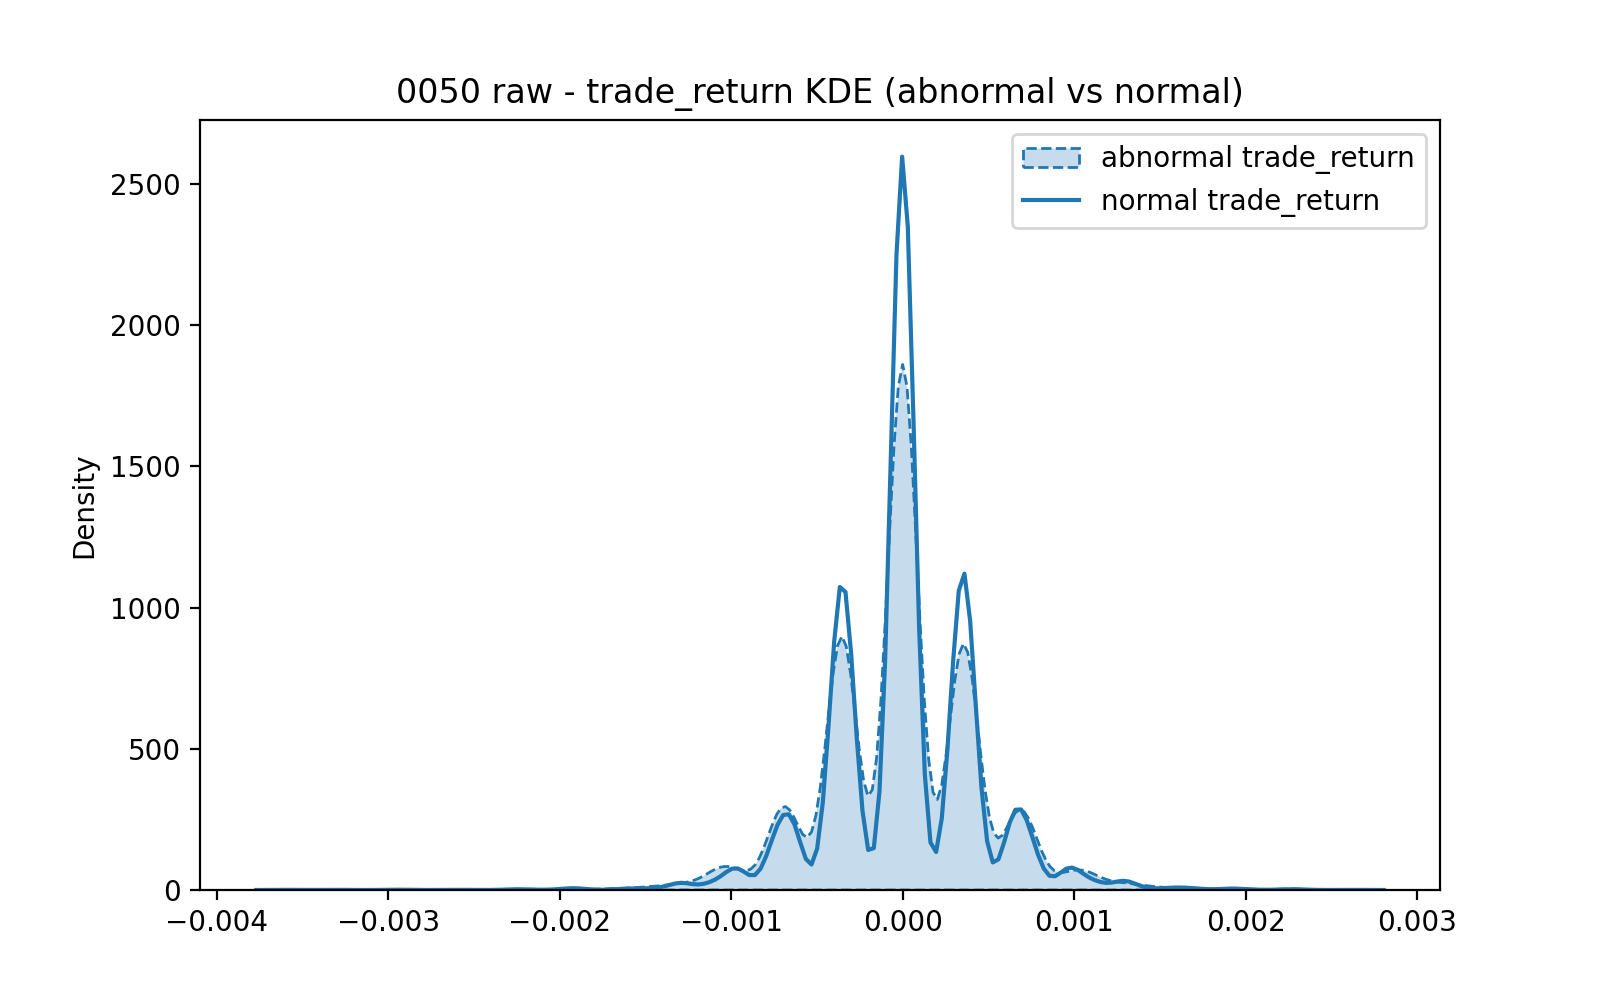

In [11]:
from IPython.display import Image


Image(filename=f"./Results/{stock_list[0]}_trade_return_KDE_raw.png")

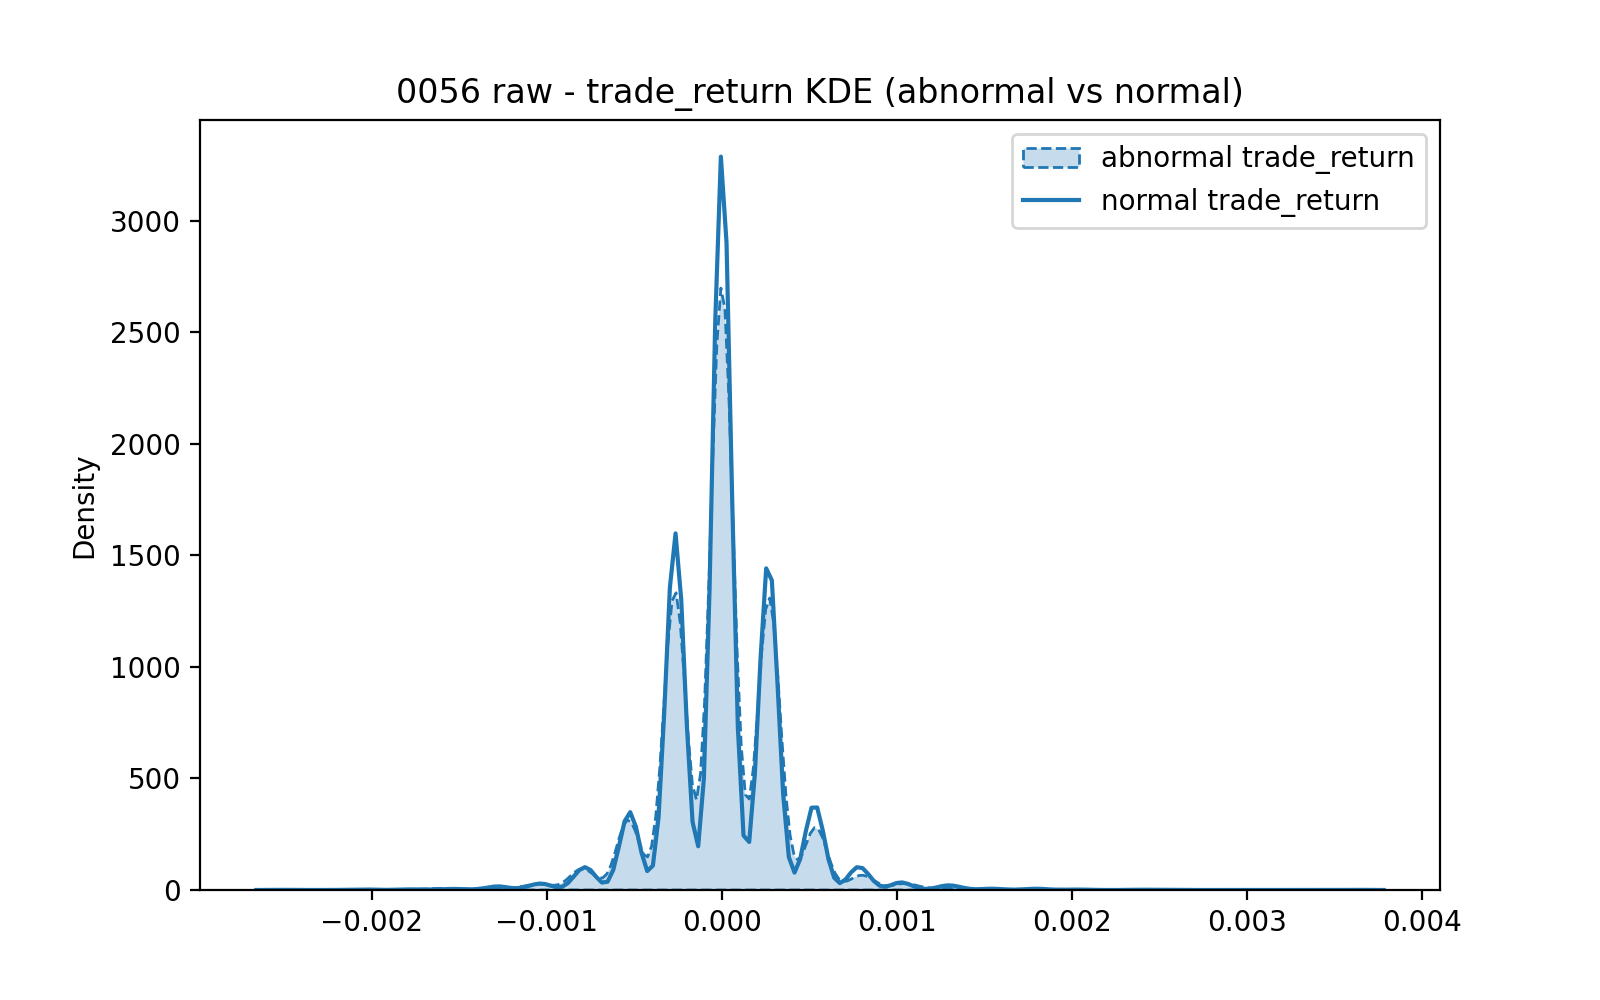

In [12]:
Image(filename=f"./Results/{stock_list[1]}_trade_return_KDE_raw.png")

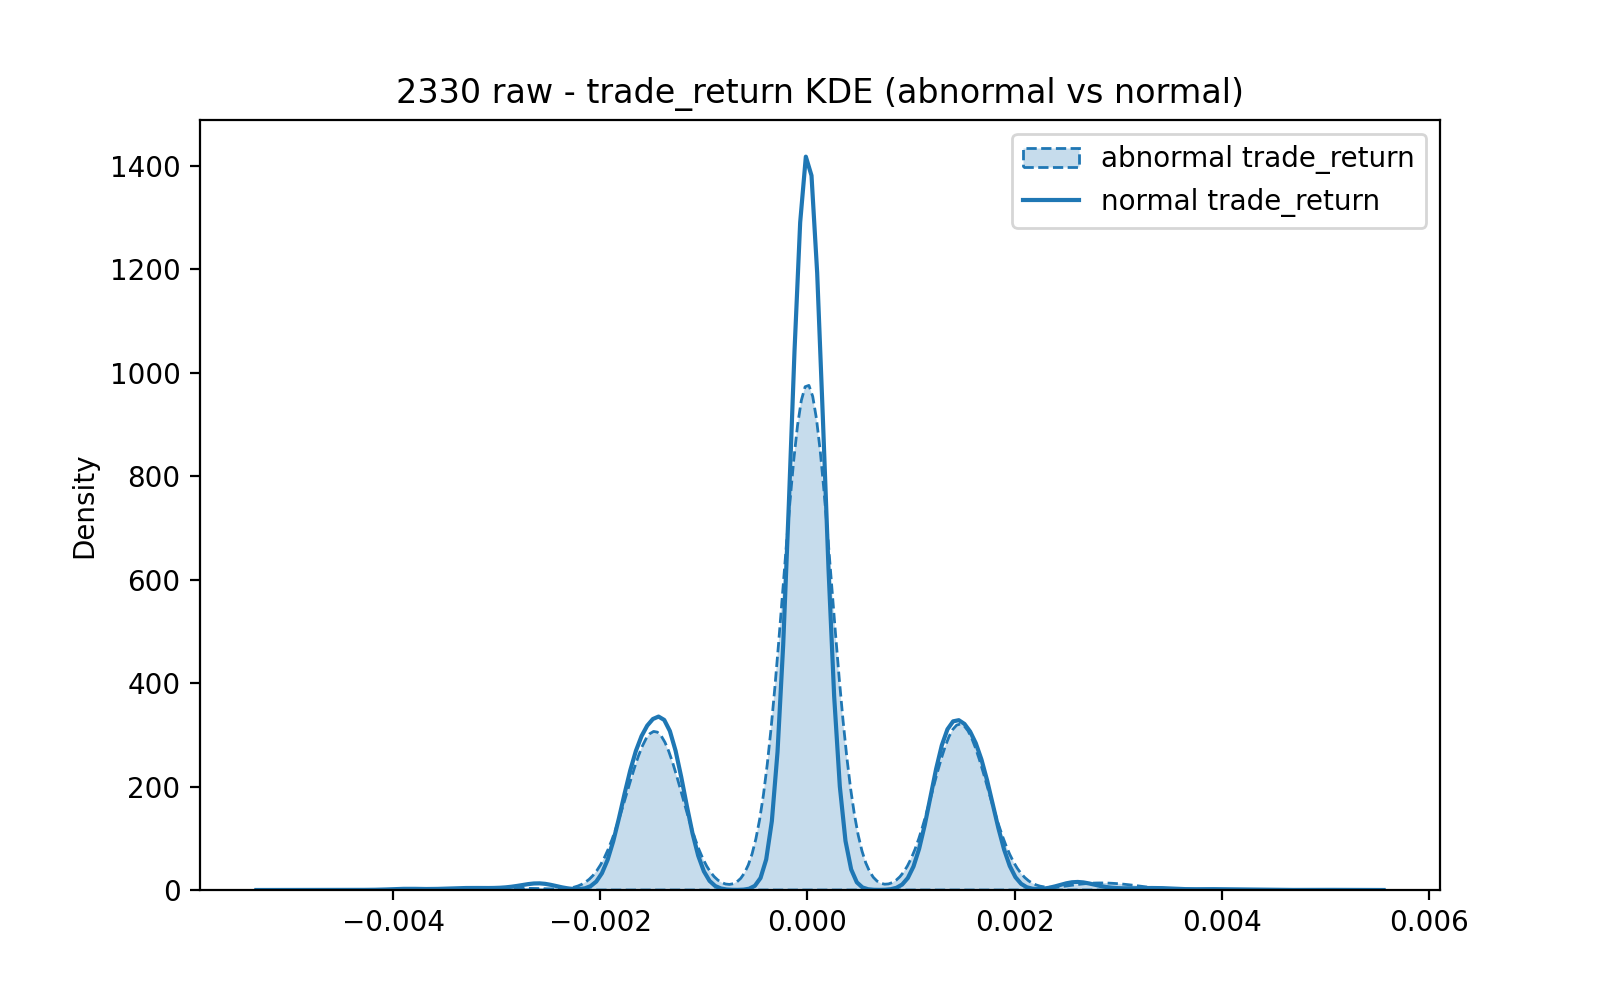

In [13]:
Image(filename=f"./Results/{stock_list[2]}_trade_return_KDE_raw.png")

In [15]:
significant

n_abn  n_norm    mean_abn    mean_norm  \
stock version variable                                               
0050  raw     pressure_1     3710   10865    0.157300     0.075284   
              mid_return     3696   10824   -0.000007     0.000006   
              trade_return   3696   10824   -0.000007     0.000006   
              pressure_5     3710   10865    0.078698     0.054403   
              spread         3710   10865    0.069299     0.067064   
0056  raw     pressure_5     3710   10865   -0.048134     0.046438   
              spread         3710   10865    0.011787     0.012718   
              pressure_1     3710   10865   -0.189590    -0.116019   
              trade_return   3696   10824   -0.000008     0.000002   
              mid_return     3696   10824   -0.000008     0.000001   
              trade_size     3710   10865  983.018868  2919.466176   
              spread_diff    3696   10824   -0.000022    -0.000007   
2330  raw     pressure_1     1590   12985   -0.079168    -0.033583   
              pressure_5     1590   12985   -0.165847    -0.121119   
              trade_return   1584   12936    0.000040    -0.000002   

                             delta_mean       var_abn      var_norm  \
stock version variable                                                
0050  raw     pressure_1       0.082016  4.758491e-01  4.650523e-01   
              mid_return      -0.000013  1.111001e-07  1.027333e-07   
              trade_return    -0.000013  1.995622e-07  1.839043e-07   
              pressure_5       0.024294  9.107648e-02  1.055525e-01   
              spread           0.002235  1.124846e-03  1.067772e-03   
0056  raw     pressure_5      -0.094572  2.928921e-01  2.650350e-01   
              spread          -0.000931  2.319455e-05  3.965397e-05   
              pressure_1      -0.073571  4.497259e-01  4.701667e-01   
              trade_return    -0.000009  1.068558e-07  1.128628e-07   
              mid_return      -0.000009  7.302207e-08  7.226792e-08   
              trade_size   -1936.447308  1.567887e+08  2.720059e+09   
              spread_diff     -0.000014  3.311641e-05  4.863261e-05   
2330  raw     pressure_1      -0.045585  1.528649e-01  1.917448e-01   
              pressure_5      -0.044728  8.246791e-02  8.899808e-02   
              trade_return     0.000042  1.028540e-06  1.098762e-06   

                            ratio_var   skew_abn  skew_norm  delta_skew  \
stock version variable                                                    
0050  raw     pressure_1     1.023216  -0.331673  -0.162190   -0.169483   
              mid_return     1.081442   0.155628   0.027294    0.128334   
              trade_return   1.085142   0.032602  -0.097710    0.130312   
              pressure_5     0.862855   0.125514   0.116725    0.008789   
              spread         1.053451   1.892086   2.299536   -0.407449   
0056  raw     pressure_5     1.105108   0.282051  -0.152000    0.434052   
              spread         0.584924   3.448253   3.238824    0.209429   
              pressure_1     0.956524   0.422295   0.248559    0.173736   
              trade_return   0.946776   0.072053   0.301003   -0.228950   
              mid_return     1.010435   0.085517   0.411951   -0.326434   
              trade_size     0.057642  30.667187  36.226875   -5.559689   
              spread_diff    0.680951   0.323754   0.103985    0.219769   
2330  raw     pressure_1     0.797231   0.346038   0.075987    0.270051   
              pressure_5     0.926626   0.295040   0.193504    0.101536   
              trade_return   0.936090   0.119607   0.023600    0.096007   

                            kurtosis_abn  kurtosis_norm  delta_kurtosis  \
stock version variable                                                    
0050  raw     pressure_1        1.598795       1.538583        0.060212   
              mid_return        7.905224      11.214181       -3.308958   
              trade_return      4.570023       6.6795

In [16]:
for stock in ["0050", "0056", "2330"]:
    print("=" * 60)
    print(f"Stock {stock} – microstructure comparison (abn vs norm)")
    print("=" * 60)

    tmp = full_table.loc[stock].copy()  # 取该股票所有变量
    # 为了便于阅读，只打印少数关键列
    cols_to_show = [
        "mean_abn", "mean_norm", "delta_mean",
        "var_abn", "var_norm", "ratio_var",
        "p_value",
    ]
    display(tmp[cols_to_show].sort_values("p_value"))


Stock 0050 – microstructure comparison (abn vs norm)


mean_abn   mean_norm  delta_mean       var_abn  \
version variable                                                          
raw     pressure_1       0.157300    0.075284    0.082016  4.758491e-01   
        mid_return      -0.000007    0.000006   -0.000013  1.111001e-07   
        trade_return    -0.000007    0.000006   -0.000013  1.995622e-07   
        pressure_5       0.078698    0.054403    0.024294  9.107648e-02   
        spread           0.069299    0.067064    0.002235  1.124846e-03   
        spread_diff     -0.000095   -0.000106    0.000012  1.427886e-03   
        trade_size    1260.916442  498.021169  762.895273  1.448129e+09   

                          var_norm  ratio_var       p_value  
version variable                                             
raw     pressure_1    4.650523e-01   1.023216  3.133739e-11  
        mid_return    1.027333e-07   1.081442  1.650846e-07  
        trade_return  1.839043e-07   1.085142  3.289841e-07  
        pressure_5    1.055525e-01   0.862855  4.108568e-06  
        spread        1.067772e-03   1.053451  7.012020e-05  
        spread_diff   1.198021e-03   1.191871  2.077955e-01  
        trade_size    5.998861e+07  24.140071  9.999933e-01

Stock 0056 – microstructure comparison (abn vs norm)


mean_abn    mean_norm   delta_mean       var_abn  \
version variable                                                           
raw     pressure_5     -0.048134     0.046438    -0.094572  2.928921e-01   
        spread          0.011787     0.012718    -0.000931  2.319455e-05   
        pressure_1     -0.189590    -0.116019    -0.073571  4.497259e-01   
        trade_return   -0.000008     0.000002    -0.000009  1.068558e-07   
        mid_return     -0.000008     0.000001    -0.000009  7.302207e-08   
        trade_size    983.018868  2919.466176 -1936.447308  1.567887e+08   
        spread_diff    -0.000022    -0.000007    -0.000014  3.311641e-05   

                          var_norm  ratio_var       p_value  
version variable                                             
raw     pressure_5    2.650350e-01   1.105108  4.157810e-41  
        spread        3.965397e-05   0.584924  1.205947e-08  
        pressure_1    4.701667e-01   0.956524  6.559929e-08  
        trade_return  1.128628e-07   0.946776  9.041592e-06  
        mid_return    7.226792e-08   1.010435  2.843640e-04  
        trade_size    2.720059e+09   0.057642  1.446346e-03  
        spread_diff   4.863261e-05   0.680951  9.376977e-03

Stock 2330 – microstructure comparison (abn vs norm)


mean_abn   mean_norm  delta_mean       var_abn  \
version variable                                                         
raw     pressure_1     -0.079168   -0.033583   -0.045585  1.528649e-01   
        pressure_5     -0.165847   -0.121119   -0.044728  8.246791e-02   
        trade_return    0.000040   -0.000002    0.000042  1.028540e-06   
        mid_return      0.000037   -0.000003    0.000040  2.105790e-07   
        trade_size    348.427673  392.760878  -44.333205  2.705013e+06   
        spread          1.003774    1.003003    0.000770  5.017207e-03   
        spread_diff     0.001263    0.000232    0.001031  7.574163e-03   

                          var_norm  ratio_var       p_value  
version variable                                             
raw     pressure_1    1.917448e-01   0.797231  2.735150e-11  
        pressure_5    8.899808e-02   0.926626  7.678636e-10  
        trade_return  1.098762e-06   0.936090  3.774649e-05  
        mid_return    2.764027e-07   0.761856  3.191405e-01  
        trade_size    5.320055e+06   0.508456  7.492244e-01  
        spread        2.994445e-03   1.675505  1.000000e+00  
        spread_diff   5.643113e-03   1.342196  1.000000e+00